# Python Data Science Handbook - Feature Engineering

[Resource](https://jakevdp.github.io/PythonDataScienceHandbook/05.04-feature-engineering.html)

# Categorical Features

Here's the example data:

In [55]:
data = [
    {'price': 850000, 'rooms': 4, 'neighborhood': 'Queen Anne'},
    {'price': 700000, 'rooms': 3, 'neighborhood': 'Fremont'},
    {'price': 650000, 'rooms': 3, 'neighborhood': 'Wallingford'},
    {'price': 600000, 'rooms': 2, 'neighborhood': 'Fremont'}
]

You might be tempted to encode this data with a straightforward numerical mapping:

In [56]:
{'Queen Anne': 1, 'Fremont': 2, 'Wallingford': 3};

It turns out that this is not generally a useful approach in Scikit-Lear: the package's models **make the fundamental assumption that numerical features reflect algebraic quantities**. Thus, such a mapping would imply, for example, that *Queen Anne < Fremont < Wallingford, or even that Wallingford - Queen Anne = Fremont* which (niche demographic jokes aside) doesn't make much sense.

(Loving the humor already from these writers.)

In this case, one proven technique is to use one-hot encoding, which effectively creates extra columns indicating the presence or absence of a category with a value of 1 or 0, respectively. When your data comes as a list of dictionaries, Scikit-Learn's `DictVectorizer` will do this for you:

In [57]:
from sklearn.feature_extraction import DictVectorizer

vec = DictVectorizer(sparse=False, dtype=int)
vec.fit_transform(data)

array([[     0,      1,      0, 850000,      4],
       [     1,      0,      0, 700000,      3],
       [     0,      0,      1, 650000,      3],
       [     1,      0,      0, 600000,      2]])

Aha! See now this is why we study before just diving in! I had no idea `DictVectorizer` existed.

Notice that the 'neighborhood' column has been expanded into three separate columns, representing the three neighborhood labels, and that each row has a 1 in the column associated with its neighborhood. With these categorical features thus encoded, you can proceed as normal with fitting a Scikit-Learn model.

To see the meaning of each column, you can inspect the feature names:

In [58]:
vec.get_feature_names_out()

array(['neighborhood=Fremont', 'neighborhood=Queen Anne',
       'neighborhood=Wallingford', 'price', 'rooms'], dtype=object)

Beautiful. Love it.

There is one clear disadvantage to this approach that you're familiar with: if your category has many possible values, this can *greatly* increase the size of your dataset, However, because the encoded data contains mostly zeros, a sparse output can be a very efficient solution:

In [59]:
cev = DictVectorizer(sparse=True, dtype=int)
vec.fit_transform(data)

array([[     0,      1,      0, 850000,      4],
       [     1,      0,      0, 700000,      3],
       [     0,      0,      1, 650000,      3],
       [     1,      0,      0, 600000,      2]])

Many (though not yet all) of the Scikit-Learn estimators accept such sparse inputs when fitting and evaluating models. `sklearn.preprocessing.OneHotEncoder` and `sklearn.feature_extraction.FeatureHasher` are two additional tools that Scikit-Learn includes to support this type of encoding.

## Text Features

Another common need in feature engineering is to convert text to a set of representative numerical values. For example, most automatic mining of social media data relies on some form of encoding the text as numbers. One of the simplest methods of encoding data is by *word counts*: you take each snippet of text, count the occurrences of each word within it, and put the results in a table.

For example, consider the following set of three phrases:

In [60]:
sample = ['problem of evil',
          'evil queen',
          'horizon problem']

For a vectorization of this data based on word count, we could construct a column representing the word "problem", the word "evil", the word "horizon", and so on. While doing this by hand would be possible, the tedium can be avoided by using Scikit-Learn's `CountVectorizer`:

In [61]:
from sklearn.feature_extraction.text import CountVectorizer

vec = CountVectorizer()
X = vec.fit_transform(sample)
X

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 7 stored elements and shape (3, 5)>

The result is a sparse matrix recording the number of times each word appears; it's easier to inspect if we convert this to a `DataFrame` with labeled columns:

In [62]:
import pandas as pd
pd.DataFrame(X.toarray(), columns=vec.get_feature_names_out())

,evil,horizon,of,problem,queen
0,1,0,1,1,0
1,1,0,0,0,1
2,0,1,0,1,0


There are some issues with this approach, however: the raw word counts lead to features which put too much weight on words that appear very frequently, and this can be sub-optimal in come classification algorithms. One approach is to fix this is known as **term frequency-inverse document frequency (TF-IDF)** which weights the word counts by a measure of how often they appear in the documents. The syntax for computing these features is similar to the previous example:

In [63]:
from sklearn.feature_extraction.text import TfidfVectorizer

vec = TfidfVectorizer()
X = vec.fit_transform(sample)
pd.DataFrame(X.toarray(), columns=vec.get_feature_names_out())

,evil,horizon,of,problem,queen
0,0.517856,0.000000,0.680919,0.517856,0.000000
1,0.605349,0.000000,0.000000,0.000000,0.795961
2,0.000000,0.795961,0.000000,0.605349,0.000000


For an example ofusing TF-IDF in a classification problem, see [here](https://jakevdp.github.io/PythonDataScienceHandbook/05.05-naive-bayes.html).

## Image Features

We're skipping this. I don't want to work with images for some time. Not enough personal use cases for me to justify its usage.

## Derived Features

Another useful type of feature is one that is mathematically derived from some input features. We can convert a linear regression into a polynomial regression not by changing the model, but by transforming the input. This is sometimes known as **basis function regression**, and is explored further [here](https://jakevdp.github.io/PythonDataScienceHandbook/05.06-linear-regression.html).

**Note:** You'll want to revisit the above resource later in this file.

For example, this data clearly cannot be well described by a straight line:

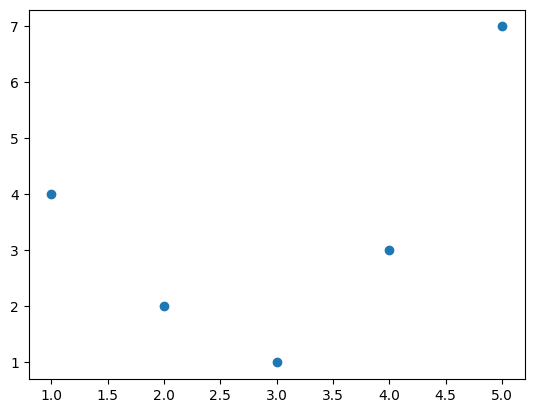

In [64]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

x = np.array([1, 2, 3, 4, 5])
y = np.array([4, 2, 1, 3, 7])
plt.scatter(x, y)

Still, we can fit a line to the data using `LinearRegression` and get the optimal result:

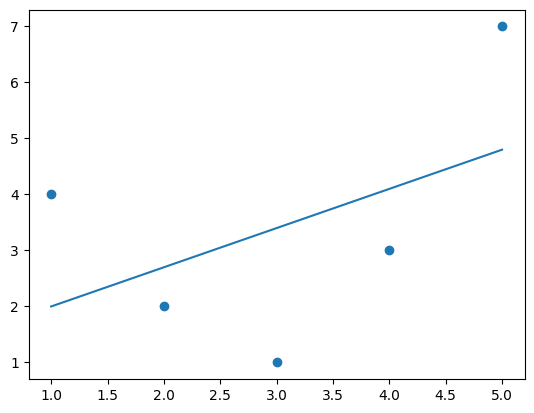

In [65]:
from sklearn.linear_model import LinearRegression

X = x[:, np.newaxis]
model = LinearRegression().fit(X, y)
yfit = model.predict(X)
plt.scatter(x, y)
plt.plot(x, yfit);

It's clear that we need a more sophisticated model to describe the relationship between `X` and `y`.

One approach to this is 4to transform the data, adding extra columns of features to drive more flexibility in the model. For example, we can add polynomial features to the data this way:

In [66]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=3, include_bias=False)
X2 = poly.fit_transform(X)
X2

array([[  1.,   1.,   1.],
       [  2.,   4.,   8.],
       [  3.,   9.,  27.],
       [  4.,  16.,  64.],
       [  5.,  25., 125.]])

The derived feature matrix has one column representing `X`, and a second column representing x^2, and a third column representing x^3. Computing a linear regression on this expanded input gives a much closer fit to our data:

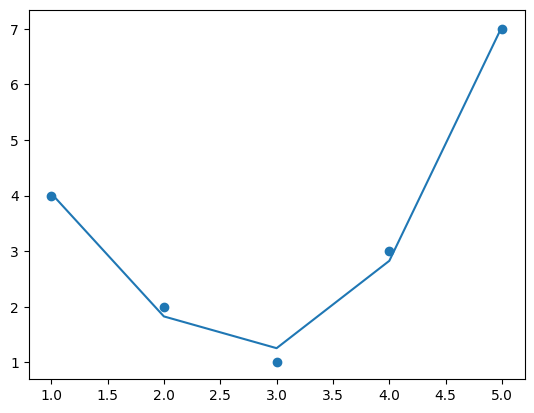

In [67]:
model = LinearRegression().fit(X2, y)
yfit = model.predict(X2)

plt.scatter(x, y)
plt.plot(x, yfit);

This idea of improving a model by not changing the model, but by transforming the inputs, is fundamental to many of the more powerful machine learning methods. Once again, this is explored more in-depth [here](https://jakevdp.github.io/PythonDataScienceHandbook/05.06-linear-regression.html) in the context of **basis function regression**. More generally, this is one motivational path to the powerful set of techniques which are explored [here](https://jakevdp.github.io/PythonDataScienceHandbook/05.07-support-vector-machines.html) (yet another deep dive resource. Perfecto.)